<a href="https://colab.research.google.com/github/arumajirou/ETNA/blob/main/get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スタート

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/get_started.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

このノートブックでは、ETNAライブラリを使った時系列予測パイプラインの簡単な例を紹介しています。

**目次**

* [TSDatasetの作成](#chapter1)
* [プロット](#chapter2)
* [単一時系列の予測](#chapter3)
    * [単純予想](#section_3_1)
    * [預言者](#section_3_2)
    * [キャットブースト](#section_3_3)
* [複数の時系列を予測する](#chapter4)
* [パイプライン](#chapter5)

In [31]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

## 1.TSDatasetの作成 <a class="anchor" id="chapter1"></a>

データセットをロードして見てみましょう。

In [32]:
import pandas as pd

In [33]:
#修正　
data_path ="https://github.com/tinkoff-ai/etna/raw/master/examples/data/monthly-australian-wine-sales.csv"

original_df = pd.read_csv(data_path)
original_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


etna_tsはデータフォーマットに厳しいです。

- **予測したい列は`target`**と呼ばれる必要があります。
- **datatime データを持つカラムは`timestamp`**と呼ばれる必要があります。
- etnaは常に複数の時系列を扱うことができるため、**`segment`も必須**です。

- このライブラリは、**特殊なデータ構造である`TSDataset`**を使用しています。

- したがって，何かを始める前に，**古典的なDataFrameを`TSDataset`に変換する必要**があります．

まずは名前を変えてみよう

In [34]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])#datatime データを持つカラムはtimestamp
original_df["target"] = original_df["sales"]#予測したい列はtarget
original_df.drop(columns=["month", "sales"], inplace=True)#変更した["month", "sales"]カラムを削除
original_df["segment"] = "main"#常に複数の時系列を扱うことができるため、segmentも必須
original_df.head() #成形したoriginal_dfの最初の5行を表示

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [35]:
!pip install --upgrade pip
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TSDatasetに変換する時が来た!

そのためには、まず、従来のDataFrameを特殊な形式に変換する必要があります。

# **tsdataset**

- TSDatasetは、時系列データを扱うためのメインクラスです。
 - TSDataset(df, freq[, df_exog, known_future])

- TSDatasetは時系列データを扱うメインクラスで、探索分析のための準備、Transformsによる特徴量の生成、未来点の生成を実装しています。

**備考**

- TSDatasetはカスタムインデックスと スライシングメソッドをサポートしています。 

 - それはこれらのインターフェイスを通して行われます。

 - TSDataset[timestamp, segment, column]

- データセットにNaNが含まれている場合、それらのタイムスタンプは削除されます。

 - 作成時、セグメントは文字列型にキャストされます。


In [36]:
from etna.datasets.tsdataset import TSDataset

In [37]:
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [38]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


これでTSDatasetを構築することができます。

データフレームに加え、データの頻度を指定する必要があります。 今回は月別のデータです。

パラメータ

- **df(pandas.core.frame.DataFrame)** - 時系列を含むデータフレーム

- **freq(str)** - dfにおけるタイムスタンプの頻度．

- **df_exog(Optional[pandas.core.frame.DataFrame])** - 外生データを含むデータフレーム。

- **known_future(Union[Literal['all'], typing.Sequence])** -df_exog[known_future]の中でリグレッサーとなる列、「all」の値が与えられた場合、全ての列がリグレッサーであることが意味される。

In [39]:
ts = TSDataset(df, freq="1M")
ts.head()

/usr/local/lib/python3.8/dist-packages/etna/datasets/tsdataset.py:124: UserWarning: You probably set wrong freq. Discovered freq in you data is MS, you set 1M
  warnings.warn(


segment,main
feature,target
timestamp,
1980-01-31,NaN
1980-02-29,NaN
1980-03-31,NaN
1980-04-30,NaN
1980-05-31,NaN


*Oups*. 修正しよう

In [40]:
ts = TSDataset(df, freq="MS")
ts.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


データセットに関する基本的な情報を見ることができます。

In [41]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


またはDataFrame形式

In [42]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


## 2. プロット(描画) <a class="anchor" id="chapter2"></a>

データセットの時系列を見てみましょう

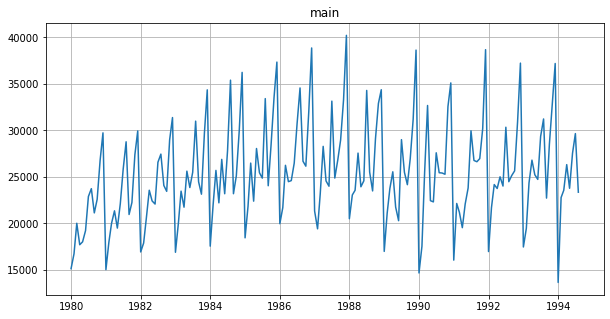

In [43]:
ts.plot()

## 3. 単一時系列の予測 <a class="anchor" id="chapter3"></a>



### 3.1 単純な予測<a class="anchor" id="section_3_1"></a>
`NaiveModel`を使って、データセットの1994年の月別値を予測してみましょう。

# **Naive Bayesアルゴリズムとは**
- ベイズの定理をもとにしたのがNaive Bayesアルゴリズムであり、以下のような特徴を持ちます。

- データが与えられたときの全ての推定の確率を計算し、最も確率の高いものを推定結果として出力
- 非常にシンプルだが、現実世界の多くの複雑な問題に対してうまく機能
- CPUとメモリに関してリソースが限られている場合に使用でき、さらにトレーニング時間が重要である場合、非常に迅速にトレーニングできて便利
- データの特徴量は独立で、互いに相関がないと仮定しており、各特徴量が独立に推定結果に影響するため、とても強い仮定において実データでは成り立たないこともある
- 強い仮定(制約)にもかかわらず、仮定が成り立たないであろう実データでも、驚くほどよい結果を出す
- その結果が、他のより複雑なアルゴリズムを越えることも多々ある

---
# **アルゴリズムの長所と短所**
以下にNaive Bayesアルゴリズムの長所と短所をまとめます。

- 長所	
 - 単純(実装も簡単)かつ強力
 - とても大きなデータセットに対しても有効
 - 高速で計算資源も少なくてよい
 - 少ないトレーニングデータでも性能が出る
 - 重要でない特徴量の影響を受けにくい
- 短所	
 - 各特徴量が独立であると仮定しなければならない(実データでは成り立たないことも多い)
- Naive Bayesアルゴリズムの応用先
 - そして以下に応用先をまとめます。 上であげた長所から、リアルタイムでの処理や文書データによく用いられています。

In [44]:
#train_test_split([train_start, train_end, ...])
#与えられたdfを、訓練とテストのタイムスタンプのインデックス、またはテストセットのサイズで分割します。
train_ts, test_ts = ts.train_test_split(
    train_start="1980-01-01",#訓練データ開始年月日
    train_end="1993-12-01",#訓練データ終了年月日
    test_start="1994-01-01",#テストデータ開始年月日
    test_end="1994-08-01",#テストデータ終了年月日
)

In [45]:
HORIZON = 8
#ナイーブモデルは、系列のt番目の値をその（t-ラグ）値で予測する。
from etna.models import NaiveModel

# モデルの適合
#lag(int) - 新しい値を予測するための遅延時間．
model = NaiveModel(lag=12)
print("model =",model)
print("*"*100)
model.fit(train_ts)
print(model.fit(train_ts))
print("*"*100)
# 予測を立てる
#make_future(future_steps[,tail_steps])
#将来のステップを含む新しいTSDatasetを返す。
future_ts = train_ts.make_future(
    future_steps=HORIZON, #機能を構築するための、将来のタイムスタンプの数です。
    tail_steps=model.context_size# 機能を構築するための、コンテキスト(前後の脈絡)のタイムスタンプ数。
    )
print("将来のタイムスタンプの数 =",HORIZON)
print("*"*100)
print("コンテキストのタイムスタンプの数 =",model.context_size)
print("*"*100)
print("コンテキストの特徴量と予想されるデコーダ長を含むデータセット =",future_ts)
print("*"*100)
forecast_ts = model.forecast(
    future_ts,# コンテキストの特徴量と予想されるデコーダ長を含むデータセット
    prediction_size=HORIZON#予測を行った後に残す、最後のタイムスタンプの数。 前のタイムスタンプがコンテキストとして使用されます。
     )
print("最後のタイムスタンプの数= ",HORIZON)
print("*"*100)
print("データセット 予測値= ",forecast_ts)

model = NaiveModel(lag = 12, )
****************************************************************************************************
NaiveModel(lag = 12, )
****************************************************************************************************
将来のタイムスタンプの数 = 8
****************************************************************************************************
コンテキストのタイムスタンプの数 = 12
****************************************************************************************************
コンテキストの特徴量と予想されるデコーダ長を含むデータセット = segment        main
feature      target
timestamp          
1993-01-01  17466.0
1993-02-01  19463.0
1993-03-01  24352.0
1993-04-01  26805.0
1993-05-01  25236.0
1993-06-01  24735.0
1993-07-01  29356.0
1993-08-01  31234.0
1993-09-01  22724.0
1993-10-01  28496.0
1993-11-01  32857.0
1993-12-01  37198.0
1994-01-01      NaN
1994-02-01      NaN
1994-03-01      NaN
1994-04-01      NaN
1994-05-01      NaN
1994-06-01      NaN
1994-07-01      NaN
1994-08-01      NaN
**********

ここで、予測時に`prediction_size`パラメータを渡しているのは、`forecast_ts`では最初の数点が`NaiveModel`のコンテキストになるように専用されているからです。

それでは、ある指標を見て、予測をプロットしてみましょう。 すべてのメソッドは、すでにetnaに組み込まれています

In [46]:
#マルチセグメント計算をサポートする対称的な平均絶対パーセンテージエラー指標。
from etna.metrics import SMAPE

In [47]:
smape = SMAPE()
print("テストデータ実測値 =",test_ts)
print("テストデータ予測値 =",forecast_ts)
smape(y_true=test_ts,#テストデータ実測値
      y_pred=forecast_ts#テストデータ予測値
      )


テストデータ実測値 = segment      main
feature    target
timestamp        
1994-01-01  13652
1994-02-01  22784
1994-03-01  23565
1994-04-01  26323
1994-05-01  23779
1994-06-01  27549
1994-07-01  29660
1994-08-01  23356
テストデータ予測値 = segment        main
feature      target
timestamp          
1994-01-01  17466.0
1994-02-01  19463.0
1994-03-01  24352.0
1994-04-01  26805.0
1994-05-01  25236.0
1994-06-01  24735.0
1994-07-01  29356.0
1994-08-01  31234.0


{'main': 11.492045838249387}

In [48]:
#予測パイプラインの予測値をプロットしたもの。
from etna.analysis import plot_forecast

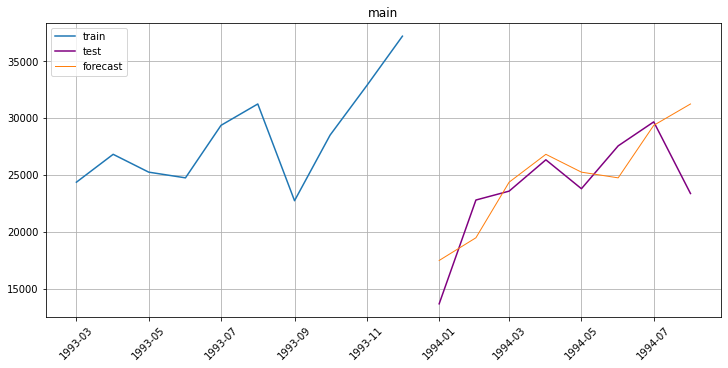

In [49]:
plot_forecast(forecast_ts, #
              test_ts,#テストデータ実測値
              train_ts,#訓練データ実測値
              n_train_samples=10#プロットする列車の履歴の長さ．
              )

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

今度は、Prophetで予測値を改善し、予測するようにしましょう。

In [50]:
print("テストデータ実測値",test_ts)
print("*"*100)
print("テストデータ予測値",forecast_ts)
smape(y_true=test_ts,#テストデータ実測値 
      y_pred=forecast_ts#テストデータ予測値 
      )

テストデータ実測値 segment      main
feature    target
timestamp        
1994-01-01  13652
1994-02-01  22784
1994-03-01  23565
1994-04-01  26323
1994-05-01  23779
1994-06-01  27549
1994-07-01  29660
1994-08-01  23356
****************************************************************************************************
テストデータ予測値 segment        main
feature      target
timestamp          
1994-01-01  17466.0
1994-02-01  19463.0
1994-03-01  24352.0
1994-04-01  26805.0
1994-05-01  25236.0
1994-06-01  24735.0
1994-07-01  29356.0
1994-08-01  31234.0


{'main': 11.492045838249387}

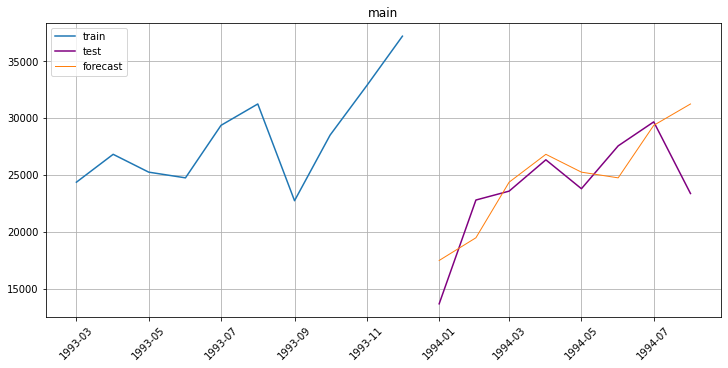

In [51]:
plot_forecast(forecast_ts, #
              test_ts,#テストデータ実測値
              train_ts,#訓練データ実測値
              n_train_samples=10#プロットする列車の履歴の長さ．
              )

### 3.2 Catboost<a class="anchor" id="section_3_3"></a>
そして最後にキャットブーストモデルを試してみましょう。

また、エトナはデータに適用する変換の種類も豊富です。

その方法を紹介します。

In [52]:
#@title ラグトランスフォーム
#指定されたデータフレームから一連のラグを生成します。
from etna.transforms import LagTransform

lags = LagTransform(
    in_column="target", #処理されるカラムの名前．
    lags=list(range(8, 24, 1))#ラグ計算のためのint値，あるいは値のリスト ここでは8~23まで
    )
print("ラグ計算のためのint値=",list(range(8, 24, 1)))
print("*"*100)
print("lags=",lags)
print("*"*100)
train_ts.fit_transform([lags])
print("train_ts.fit_transform([lags])=",train_ts.fit_transform([lags]))

ラグ計算のためのint値= [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
****************************************************************************************************
lags= LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], out_column = None, )
****************************************************************************************************
train_ts.fit_transform([lags])= None


In [53]:
#@title キャットブーストマルチセグメントモデル
#すべてのセグメントに対してCatboostモデルを保持するためのクラス。
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
print(train_ts)
model.fit(train_ts)
print("モデル種類=",model.fit(train_ts))
future_ts = train_ts.make_future(HORIZON)
print("将来のステップを含む新しいTSDataset=",future_ts)
forecast_ts = model.forecast(future_ts)
print("予測値=",forecast_ts)

segment                                                                    main  \
feature    LagTransform(in_column = 'target', lags = [10], out_column = None, )   
timestamp                                                                         
1980-01-01                                                NaN                     
1980-02-01                                                NaN                     
1980-03-01                                                NaN                     
1980-04-01                                                NaN                     
1980-05-01                                                NaN                     
...                                                       ...                     
1993-08-01                                            25650.0                     
1993-09-01                                            30923.0                     
1993-10-01                                            37240.0                     
1993

ValueError: ignored

In [54]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, 
      y_pred=forecast_ts)

{'main': 11.492045838249387}

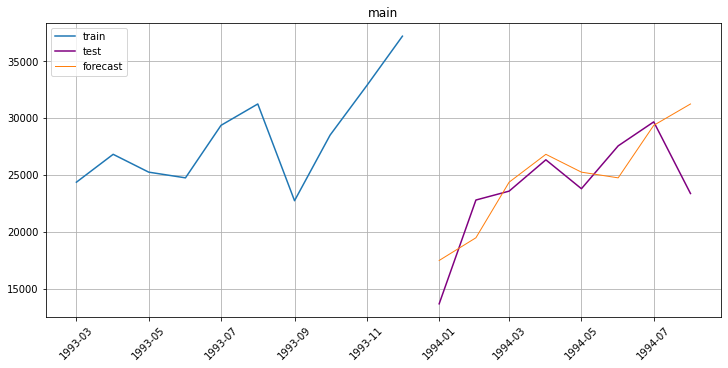

In [55]:
from etna.analysis import plot_forecast

train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

## 4. 複数の時系列を予測する <a class="anchor" id="chapter4"></a>

このセクションでは、エトナがいかに簡単に複数の時系列を扱うことができるかの例をご覧いただき、エトナが含む他の変換についてご理解いただくことができます。

In [56]:
csv_path2 ="https://raw.githubusercontent.com/tinkoff-ai/etna/master/examples/data/example_dataset.csv"
original_df = pd.read_csv(csv_path2)
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


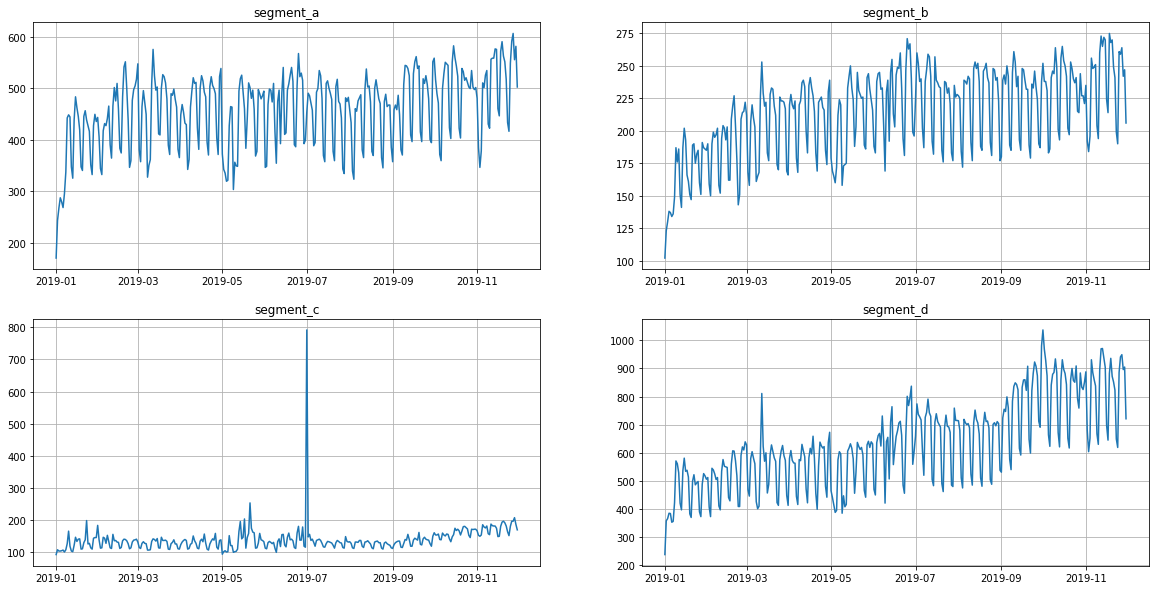

In [58]:
#pandasのdataframeをETNADataset形式に変換します。
df = TSDataset.to_dataset(original_df)
#TSDatasetは時系列データを扱うメインクラスで、探索分析のための準備、Transformsによる特徴量の生成、未来点の生成を実装しています。
ts = TSDataset(df, freq="D")#freq="D"　日次
#ランダムまたは選択されたセグメントのプロット。
ts.plot()

# **info(segments: Optional[Sequence[str]] = None)**
結果を表示するデータセットの概要。

- データセットを分割単位で記述する方法です。

- データセットに関する一般的な情報。

 - **num_segments:** 分割の総数

 - **num_exogs:** 外生的特徴の数

 - **num_regressors:** 回帰となる外生因子の個数

 - **num_known_future:** 作成時から既知のリグレッサーの個数

 - **freq:** データセットの頻度

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-01-01    2019-11-30     334            0
segment_b      2019-01-01    2019-11-30     334            0
segment_c      2019-01-01    2019-11-30     334            0
segment_d      2019-01-01    2019-11-30     334            0


In [59]:
import warnings

from etna.transforms import (
    MeanTransform,#MeanTransformは、与えられたウィンドウの平均値を計算します。
    LagTransform,#指定されたデータフレームから一連のラグを生成します。
    LogTransform,#LogTransformは、指定された系列に対して対数変換を行います。
    SegmentEncoderTransform,#分割ラベルをカテゴリカルに記号化する。カラム 'segment_code' を作成する。
    DateFlagsTransform,#DateFlagsTransformは、datetime カラムから日付に基づく主要な特徴を抽出する機能を実装したクラスである。
    LinearTrendTransform,#sklearn.linear_model.LinearRegressionを使って、データの線形または多項式の傾向を見つける変換を行います。
)

warnings.filterwarnings("ignore")#
#LogTransformは、指定された系列に対して対数変換を行います
log = LogTransform(in_column="target")#in_column(str) - 変換を適用する列．
print("対数変換 =",log)
print("*"*100)

#データの線形または多項式の傾向を見つける変換を行います。
trend = LinearTrendTransform(in_column="target")#in_column(str) - 変換を適用する列．
print("傾向 =",trend)
print("*"*100)

#分割ラベルをカテゴリカルに記号化する。
#カラム 'segment_code' を作成する。
seg = SegmentEncoderTransform()
print("分割 =",seg)
print("*"*100)

#指定されたデータフレームから一連のラグを生成します。
lags = LagTransform(in_column="target",#in_column(str) - 変換を適用する列．
                    lags=list(range(30, 96, 1))#ラグ計算のためのint値 30~95までのリスト
                    )
print("lags =",lags)
print("*"*100)

#DateFlagsTransformは、datetime カラムから
#日付に基づく主要な特徴を抽出する機能を実装したクラスである。
d_flags = DateFlagsTransform(
    day_number_in_week=True,#rue の場合、変換後の特徴データフレームに曜日情報を持つカラムを追加します。
    day_number_in_month=True,# True の場合、変換後の特徴量データフレームに日数情報を持つカラムを追加します。
    week_number_in_month=True,# True の場合、変換後の特徴データフレームに週番号を含むカラムを追加します
    week_number_in_year=True,# True の場合、変換後の特徴量データフレームに週番号の列を追加します
    month_number_in_year=True,# True の場合、変換後の特徴データフレームに月の情報を持つカラムを追加します。
    year_number=True,#True の場合、変換後の特徴量データフレームに年情報を含む列を追加します。
    special_days_in_week=[5, 6],#特別な日として解釈される日数のリスト ([1, 31] から)、
                                #与えられた場合は、与えられた日付が特別な日であることを示すフラグを持つ列を追加します。
)
print("d_flags =",d_flags)
print("*"*100)

#MeanTransformは、与えられた一定の時間間隔の平均値を計算します。
mean30 = MeanTransform(in_column="target",#in_column(str) - 変換を適用する列．
                       window=30)#一定の時間間隔
print("mean30 =",mean30)
print("*"*100)

対数変換 = LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, )
****************************************************************************************************
傾向 = LinearTrendTransform(in_column = 'target', poly_degree = 1, )
****************************************************************************************************
分割 = SegmentEncoderTransform()
****************************************************************************************************
lags = LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, )
****************************************************************************************************
d_flags = DateFlagsTransform(day_number_in_week = True, day_number_in_mo

In [60]:
HORIZON = 30
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)
train_ts.fit_transform([log, trend, lags, d_flags, seg, mean30])

In [61]:
test_ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 4
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
          start_timestamp end_timestamp  length  num_missing
segments                                                    
segment_a      2019-11-01    2019-11-30      30            0
segment_b      2019-11-01    2019-11-30      30            0
segment_c      2019-11-01    2019-11-30      30            0
segment_d      2019-11-01    2019-11-30      30            0


In [62]:
#すべてのセグメントに対してCatboostモデルを保持するためのクラス。
from etna.models.catboost import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [63]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_b': 4.210896545479218,
 'segment_a': 6.059390208724578,
 'segment_d': 4.987840592553309,
 'segment_c': 11.729007773459314}

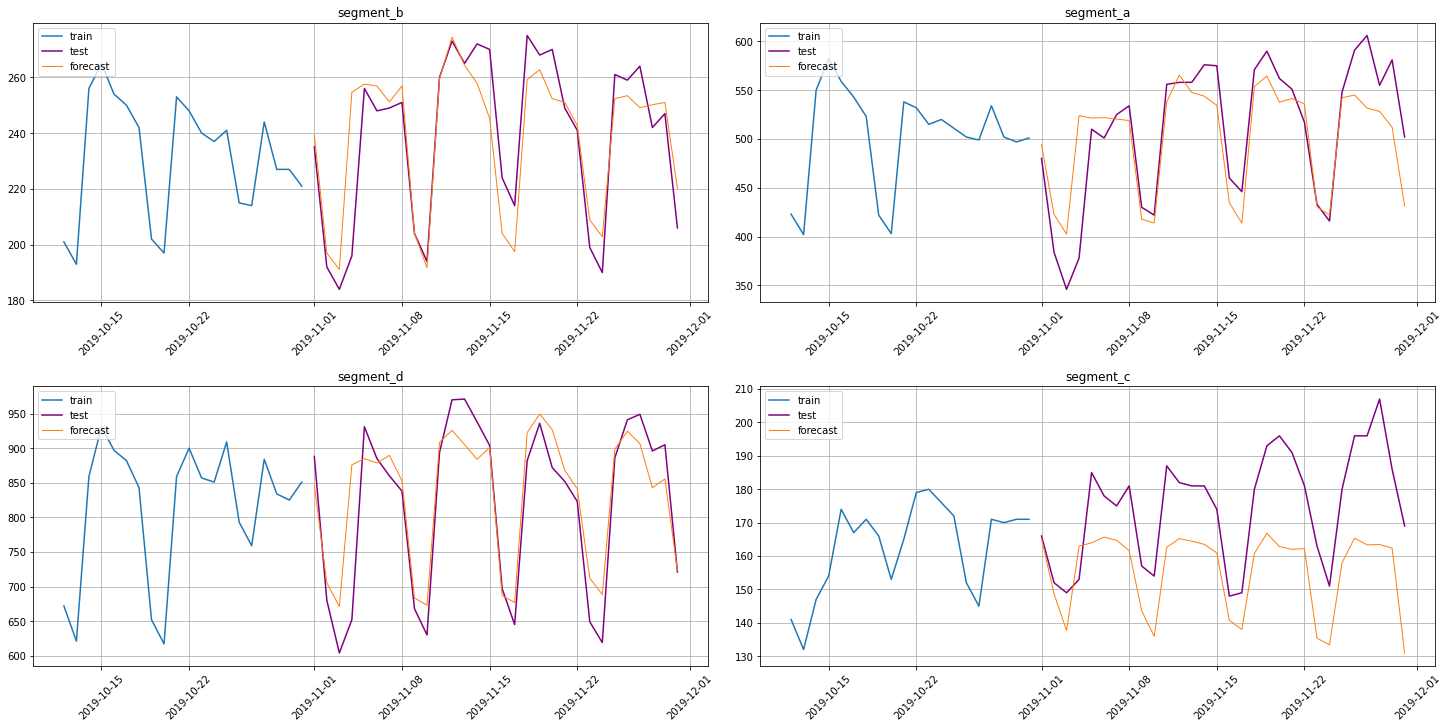

In [64]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

## 5. パイプライン <a class="anchor" id="chapter5"></a>

前節のエンドツーエンドモデルを作るために、すべてをパイプラインに包んでしまいましょう。

In [65]:
#最終的な推定量による変換のパイプライン。
from etna.pipeline import Pipeline

In [66]:
train_ts, test_ts = ts.train_test_split(
    train_start="2019-01-01",
    train_end="2019-10-31",
    test_start="2019-11-01",
    test_end="2019-11-30",
)

モデル、変換、`horizon`を一つのオブジェクトにまとめ、モデル`(fit/forecast)`と同様のインターフェイスを持つようにしました。

In [67]:
model = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[log, trend, lags, d_flags, seg, mean30],
    horizon=HORIZON,
)
print("model =",model)
model.fit(train_ts)
forecast_ts = model.forecast()
print("予測値",forecast_ts)

model = Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = True, month_number_in_year = True, season_number = False, year_number = True, is_weekend = True, special_days_in_week = [5, 6], special_days_in_month = (), out_column = None, ), Se

前項と同様に、指標を計算し、予測をプロットしてみましょう。

In [68]:
smape = SMAPE()
smape(y_true=test_ts,#テストデータ実測値
      y_pred=forecast_ts)#テストデータ予測値

{'segment_b': 4.210896545479218,
 'segment_a': 6.059390208724578,
 'segment_d': 4.987840592553309,
 'segment_c': 11.729007773459314}

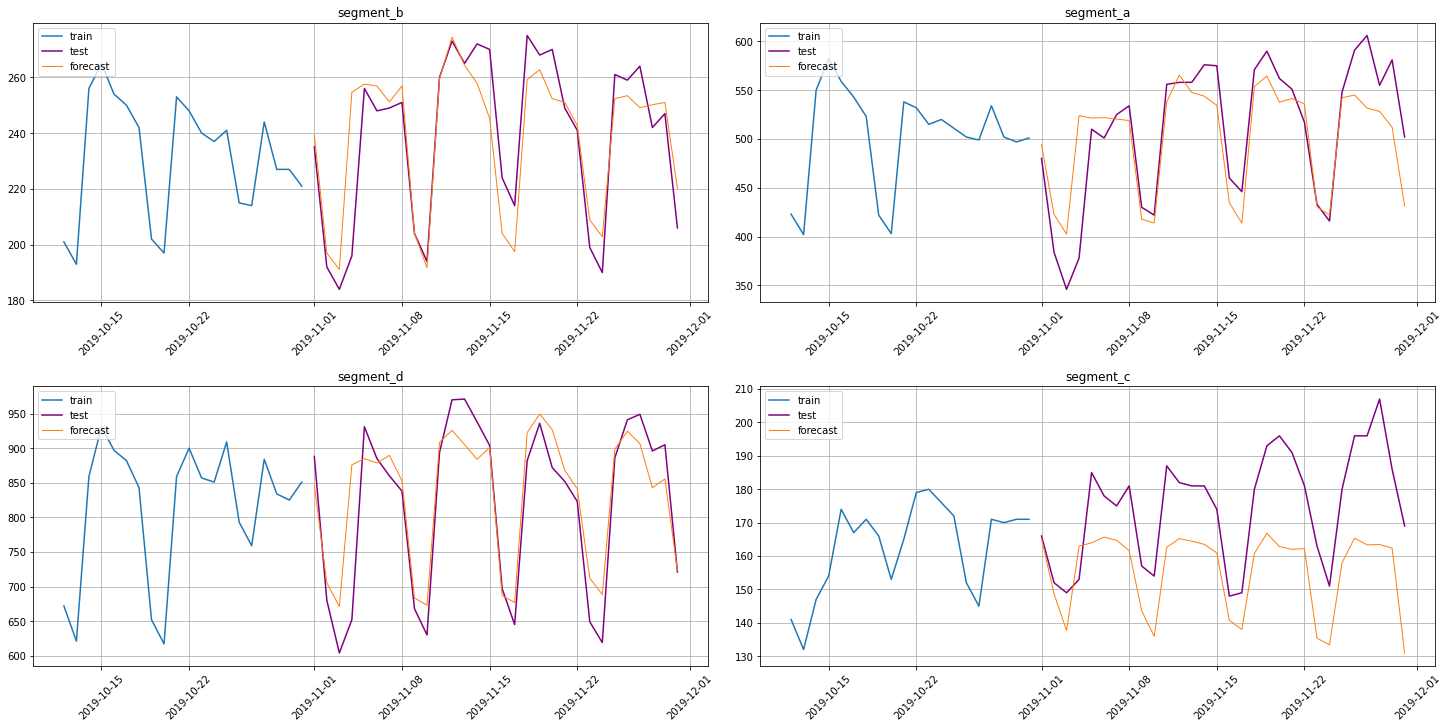

In [69]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)